In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# # Initialize the video capture object
# video_path = '/home/ikharitonov/Desktop/20204321_343_5.avi'
# cap = cv2.VideoCapture(video_path)

# # Initialize the background subtractor
# fgbg = cv2.createBackgroundSubtractorMOG2(history=5000, varThreshold=50, detectShadows=True)

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Apply the background subtractor to get the foreground mask
#     fgmask = fgbg.apply(frame)

#     # Remove noise by applying a series of erosions and dilations
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
#     fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel)

#     # Apply GaussianBlur to reduce noise and improve circle detection
#     blurred = cv2.GaussianBlur(fgmask, (9, 9), 2, 2)

#     # Detect circles in the blurred image
#     circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=50, param2=30, minRadius=5, maxRadius=50)

#     if circles is not None:
#         circles = np.uint8(np.around(circles))
#         for i in circles[0, :]:
#             # Draw the outer circle
#             cv2.circle(frame, (i[0], i[1]), i[2], (0, 255, 0), 2)
#             # Draw the center of the circle
#             cv2.circle(frame, (i[0], i[1]), 2, (0, 0, 255), 3)

#     # Display the result
#     cv2.imshow('Frame', frame)
#     cv2.imshow('Foreground Mask', fgmask)

#     # Break the loop if 'q' is pressed
#     if cv2.waitKey(30) & 0xFF == ord('q'):
#         break

# # Release the video capture object and close all OpenCV windows
# cap.release()
# cv2.destroyAllWindows()


In [3]:
# Loading the video and selecting one frame
video_path = '/home/ikharitonov/Desktop/20204321_343_5.avi'
cap = cv2.VideoCapture(video_path)
frame_number=1000
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
res, frame = cap.read()
frame.shape

(300, 300, 3)

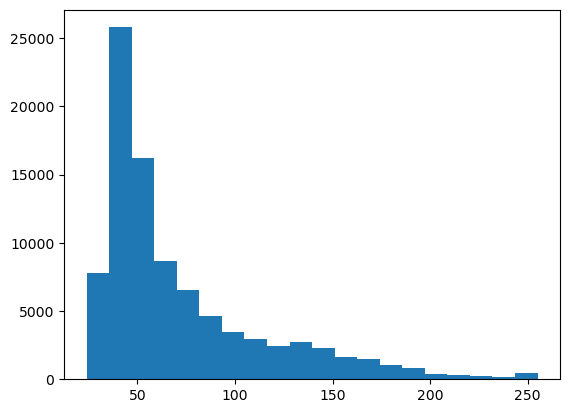

In [4]:
# Grayscaling and plotting the histogram of the image
img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

plt.hist(img.flatten(), bins=20)
plt.show()

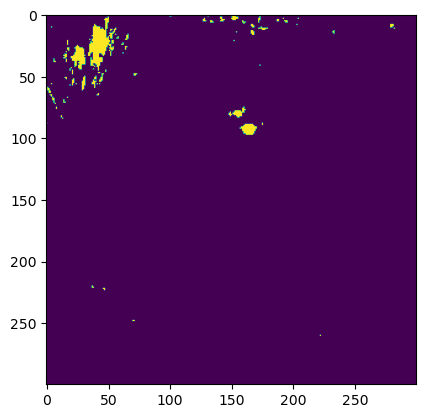

In [5]:
# Thresholding the image with max val minus one standard deviation
threshold = img.max() - img.std()
ret, th1 = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

plt.imshow(th1)
plt.show()

In [6]:
# Trying to fit circles to the image
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=50, param2=30, minRadius=10, maxRadius=50)
circles

array([[[145.5,  52.5,  49.4],
        [ 85.5,  62.5,  49.4],
        [ 33.5,  53.5,  33.8],
        [146.5, 112.5,  49.4],
        [256.5,  33.5,  33.8],
        [198.5,  65.5,  33.8],
        [245.5, 262.5,  27.2],
        [ 53.5, 242.5,  35. ],
        [ 21.5, 103.5,  19.4],
        [ 66.5,  15.5,  12.7],
        [207.5,   8.5,  17.2]]], dtype=float32)

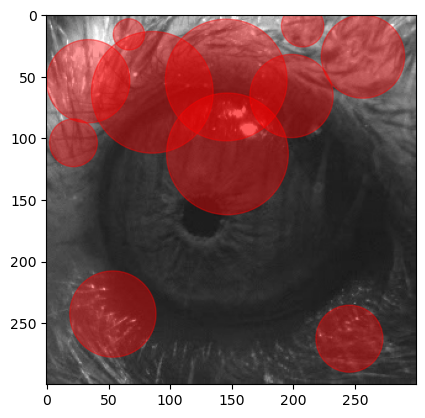

In [7]:
plt.imshow(frame[:,:,:])
for c in circles[0,:]:
    circle_to_plot = plt.Circle((c[0], c[1]), c[2], color='r', alpha=0.4)
    plt.gca().add_patch(circle_to_plot)
plt.show()

In [8]:
# Finding contours in the thresholded image
contours, _ = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

72

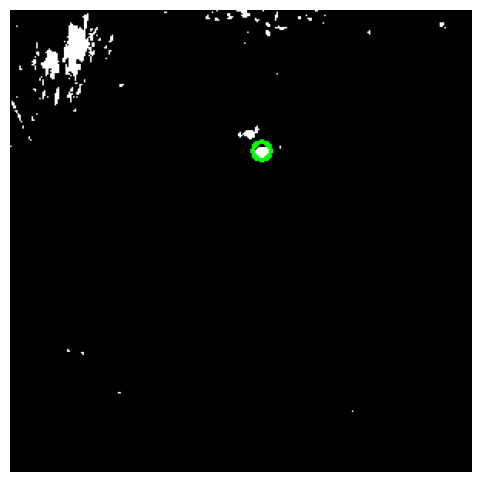

In [9]:
# Plotting detected contours
for contour in contours:
    # Approximate the contour to a circle
    (x, y), r = cv2.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(r)
    
    # Calculate circularity: (4 * π * Area) / Perimeter^2
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter > 0:
        circularity = (4 * np.pi * area) / (perimeter * perimeter)
        # Check if the circularity is close to 1 (perfect circle)
        if 0.7 < circularity < 1.3:
            circular_contour = contour
            break

# Draw the detected circle on the image (if found)
if circular_contour is not None:
    output_image = cv2.cvtColor(th1, cv2.COLOR_GRAY2BGR)
    cv2.circle(output_image, center, radius, (0, 255, 0), 2)
else:
    output_image = thresholded_image.copy()

# Display the result
plt.figure(figsize=(6, 6))
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
# Collecting contour data (circularity, center point coordinates, radius, area) into an array
contour_data = []

for i, contour in enumerate(contours):
    (x, y), r = cv2.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(r)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter > 0:
        circularity = (4 * np.pi * area) / (perimeter * perimeter)
        contour_data.append((i,circularity, center[0], center[1], radius, area))
contour_data = np.array(contour_data)

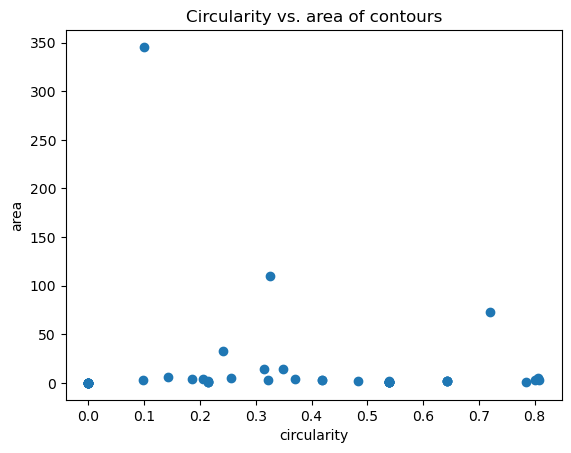

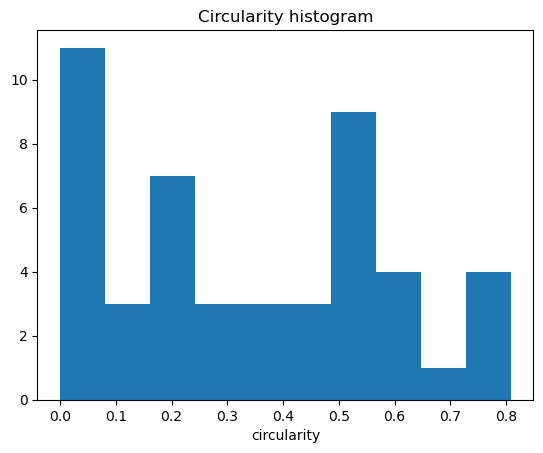

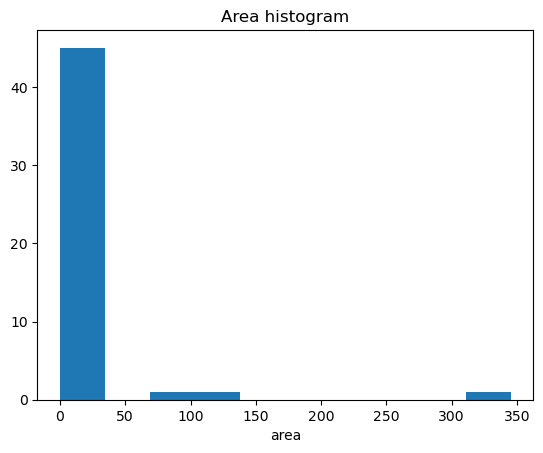

In [11]:
plt.title('Circularity vs. area of contours')
plt.scatter(contour_data[:,1], contour_data[:,5])
plt.xlabel('circularity')
plt.ylabel('area')
plt.show()

plt.title('Circularity histogram')
plt.hist(contour_data[:,1])
plt.xlabel('circularity')
plt.show()

plt.title('Area histogram')
plt.hist(contour_data[:,5])
plt.xlabel('area')
plt.show()

In [12]:
np.mean(contour_data[:,5])

13.645833333333334

In [13]:
# Trying to find the most circular circle
max_circularity_ind = np.argmax(contour_data[:,1])
center = (int(contour_data[max_circularity_ind][2]), int(contour_data[max_circularity_ind][3]))
radius = int(contour_data[max_circularity_ind][4])
center

(167, 9)

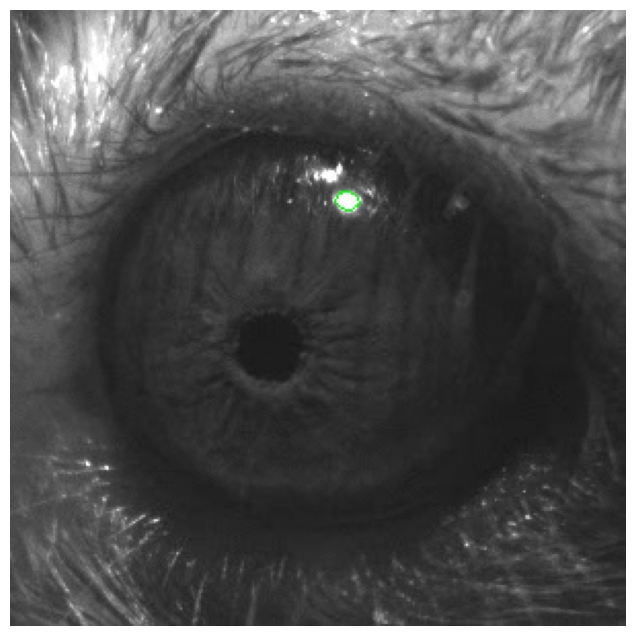

In [14]:
# Searching for the contour by eye in the area-circularity plot
min_area = 50
max_area = 100

contour_data_ind = np.where((contour_data[:,5] >= min_area) & (contour_data[:,5] <= max_area))[0][0]
contour_ind = int(contour_data[contour_data_ind,0])

cv2.ellipse(frame, cv2.fitEllipse(contours[contour_ind]), (0, 255, 0), 1)

plt.figure(figsize=(8, 8))
plt.imshow(frame)
plt.axis('off')
plt.show()

In [15]:
# Filtering the contours by the number of associated points
numbers_of_points = np.array([(i, c.shape[0]) for i,c in enumerate(contours)]) # [[contour_ind, number_of_points], ...]
countour_inds_above_5 = np.where(numbers_of_points[:,1] >= 5)
contours_above_5 = list(np.array(contours)[countour_inds_above_5])

/home/ikharitonov/anaconda3/envs/mres_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [16]:
# Fitting ellipses to contours with more than 5 points
fitted_ellipses = [cv2.fitEllipse(c) for c in contours_above_5]
fitted_ellipses

[((163.90200805664062, 92.59202575683594),
  (8.915101051330566, 11.765142440795898),
  94.94261169433594),
 ((154.56002807617188, 79.10152435302734),
  (7.707829475402832, 12.20699691772461),
  62.64719009399414),
 ((5.299404144287109, 68.41376495361328),
  (1.5373574495315552, 8.365520477294922),
  150.5851287841797),
 ((1.881773591041565, 61.24787902832031),
  (1.4814743995666504, 4.765446186065674),
  155.1739959716797),
 ((21.5, 54.599998474121094), (0.0, 1.0), 180.0),
 ((38.409690856933594, 55.595279693603516),
  (2.6456146240234375, 9.840317726135254),
  13.523983001708984),
 ((30.0, 55.5), (2.716506004333496, 11.513541221618652), 13.728370666503906),
 ((44.59532928466797, 51.24816131591797),
  (2.0592362880706787, 6.987100124359131),
  20.12363624572754),
 ((15.161871910095215, 34.76089096069336),
  (2.2185447216033936, 7.352118492126465),
  178.7373504638672),
 ((26.0214786529541, 34.31734848022461),
  (10.343914985656738, 16.652589797973633),
  177.293701171875),
 ((65.642875

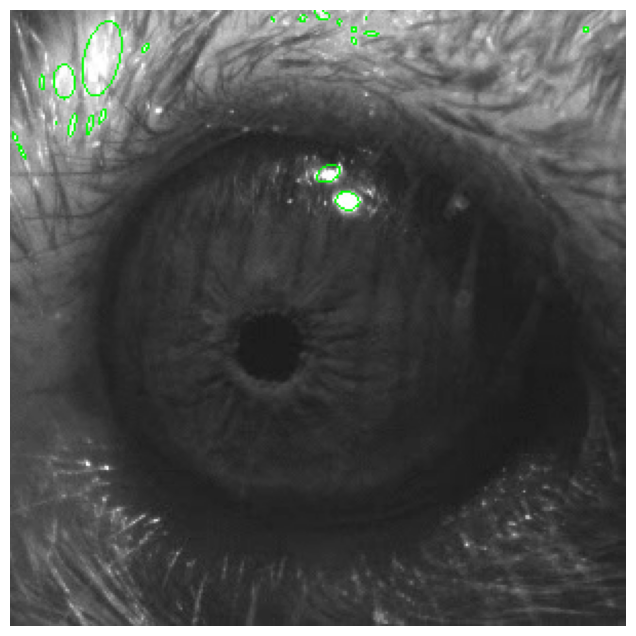

In [17]:
for e in fitted_ellipses:
    cv2.ellipse(frame, e, (0, 255, 0), 1)

# Display the result
plt.figure(figsize=(8, 8))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow(frame)
plt.axis('off')
plt.show()

In [58]:
def euclidean_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def get_ellipse_xy(contour):
    (x,y),_,_ = cv2.fitEllipse(contour)
    return (x,y)

def heuristic_contour_selection(selected_contours):
    # Check that each element in the input list of contours has at least five points
    # Is located at the coordinate with the lowest distance from the center of the image
    selected_contours = [c for c in selected_contours if c.shape[0] >= 5]
    center_point = (img.shape[0]//2, img.shape[1]//2)
    distances = [euclidean_distance(center_point, get_ellipse_xy(c)) for c in selected_contours]

    return selected_contours[np.argmin(distances)]

def get_coordinates_method_two(contours):
    
    contour_data = []

    for i, contour in enumerate(contours):
        (x, y), r = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(r)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter > 0:
            circularity = (4 * np.pi * area) / (perimeter * perimeter)
            contour_data.append((i,circularity, center[0], center[1], radius, area))
    contour_data = np.array(contour_data)
    
    # Selecting the contour with maximum area out of all contours filtered by circularity value
    threshold_circularity = 0.6
    selected_max_circularity_contours = contour_data[np.where(contour_data[:,1] > threshold_circularity), :][0]
    # max_area_contour_ind = int(selected_max_circularity_contours[np.argmax(selected_max_circularity_contours[:,5]), 0])
    max_contour_inds_desc_order = selected_max_circularity_contours[np.argsort(selected_max_circularity_contours[:,5])[::-1], 0].astype(int)
    selected_contours = list(np.array(contours, dtype=object)[max_contour_inds_desc_order])
    
    return cv2.fitEllipse(heuristic_contour_selection(selected_contours))
    
#     (x,y),_,_ = cv2.fitEllipse(contours[max_area_contour_ind])
    
#     return x,y
#     if contours[max_area_contour_ind].shape[0] < 5:
#         return None
#     else:
#         return cv2.fitEllipse(contours[max_area_contour_ind])

In [59]:
# Plotting
video_path = '/home/ikharitonov/Desktop/20204321_343_5.avi'
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    threshold = img.max() - img.std()
    ret, th1 = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    if not ret:
        break

    contours, _ = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = get_coordinates_method_two(contours)
    if not ellipse:
        pass
    else:
        cv2.ellipse(frame, ellipse, (0, 255, 0), 2)

    # Display the result
    cv2.imshow('Frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# Release the video capture object and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

ValueError: attempt to get argmin of an empty sequence

In [45]:
def euclidean_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def get_ellipse_xy(contour):
    (x,y),_,_ = cv2.fitEllipse(contour)
    return (x,y)

def heuristic_contour_selection(selected_contours):
    # Check that each element in the input list of contours has at least five points
    # Is located at the coordinate with the lowest distance from the center of the image
    selected_contours = [c for c in selected_contours if c.shape[0] >= 5]
    center_point = (img.shape[0]//2, img.shape[1]//2)
    distances = [euclidean_distance(center_point, get_ellipse_xy(c)) for c in selected_contours]

#     return selected_contours[np.argmin(distances)]
    return list(np.array(selected_contours)[np.argsort(distances)])

def get_coordinates_method_two(contours):
    
    contour_data = []

    for i, contour in enumerate(contours):
        (x, y), r = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(r)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter > 0:
            circularity = (4 * np.pi * area) / (perimeter * perimeter)
            contour_data.append((i,circularity, center[0], center[1], radius, area))
    contour_data = np.array(contour_data)
    
    # Selecting the contour with maximum area out of all contours filtered by circularity value
    threshold_circularity = 0.6
    selected_max_circularity_contours = contour_data[np.where(contour_data[:,1] > threshold_circularity), :][0]
    # max_area_contour_ind = int(selected_max_circularity_contours[np.argmax(selected_max_circularity_contours[:,5]), 0])
    max_contour_inds_desc_order = selected_max_circularity_contours[np.argsort(selected_max_circularity_contours[:,5])[::-1], 0].astype(int)
    selected_contours = list(np.array(contours, dtype=object)[max_contour_inds_desc_order])
    
    return [cv2.fitEllipse(c) for c in heuristic_contour_selection(selected_contours)]
    
#     (x,y),_,_ = cv2.fitEllipse(contours[max_area_contour_ind])
    
#     return x,y
#     if contours[max_area_contour_ind].shape[0] < 5:
#         return None
#     else:
#         return cv2.fitEllipse(contours[max_area_contour_ind])

def run_pipeline(videopath):
    output_ellipse_data = []
    
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        threshold = img.max() - img.std()
        ret, th1 = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        if not ret:
            break

        contours, _ = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        output_ellipse_data.append(get_coordinates_method_two(contours))
#         if not ellipse:
#             pass
#         else:
#             cv2.ellipse(frame, ellipse, (0, 255, 0), 2)

#         # Display the result
#         cv2.imshow('Frame', frame)


    # Release the video capture object and close all OpenCV windows
    cap.release()
#     cv2.destroyAllWindows()
    return output_ellipse_data


output_ellipse_data = run_pipeline('/home/ikharitonov/Desktop/20204321_343_5.avi')

/home/ikharitonov/anaconda3/envs/mres_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [46]:
output_ellipse_data

[[((160.24496459960938, 92.26486206054688),
   (7.722509384155273, 11.235570907592773),
   101.50630187988281),
  ((153.48965454101562, 10.748529434204102),
   (2.6428894996643066, 3.883896827697754),
   140.57057189941406),
  ((167.8331298828125, 11.166862487792969),
   (4.111021041870117, 5.355077743530273),
   45.0),
  ((173.11538696289062, 1.5691604614257812),
   (1.928454041481018, 3.6858346462249756),
   26.314340591430664)],
 [((160.23318481445312, 92.19548797607422),
   (7.550583362579346, 11.354909896850586),
   101.23088073730469),
  ((152.6017303466797, 10.321152687072754),
   (2.6837708950042725, 5.823505401611328),
   120.41232299804688),
  ((11.03344440460205, 66.46847534179688),
   (2.10502552986145, 4.647357940673828),
   6.208344459533691)],
 [((160.33120727539062, 92.17945861816406),
   (7.5337653160095215, 11.156756401062012),
   103.17655944824219),
  ((153.48965454101562, 10.748529434204102),
   (2.6428894996643066, 3.883896827697754),
   140.57057189941406),
  ((4

In [47]:
np.save('/home/ikharitonov/Desktop/20204321_343_5_ellipse_data.npy', np.array(output_ellipse_data))

/home/ikharitonov/anaconda3/envs/mres_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


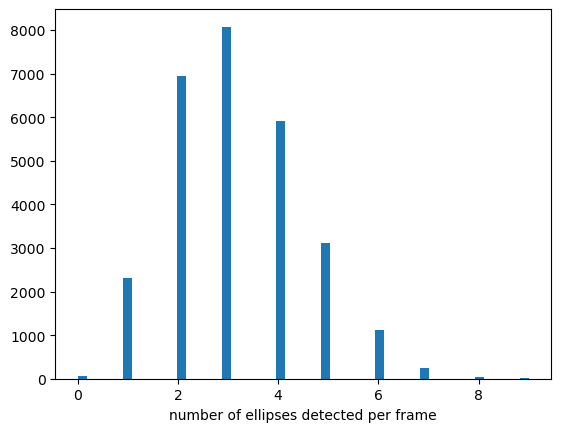

In [48]:
number_of_ellipses_per_frame = []
for ellipse_list in output_ellipse_data:
    number_of_ellipses_per_frame.append(len(ellipse_list))

plt.hist(number_of_ellipses_per_frame, bins=50)
plt.xlabel('number of ellipses detected per frame')
plt.show()

In [56]:
closest_ellipse_x_timeseries = np.zeros(len(output_ellipse_data))
closest_ellipse_y_timeseries = np.zeros(len(output_ellipse_data))

for i in range(len(output_ellipse_data)):
    if len(output_ellipse_data[i]) > 0:
        closest_ellipse_x_timeseries[i] = output_ellipse_data[i][0][0][0]
        closest_ellipse_y_timeseries[i] = output_ellipse_data[i][0][0][1]

In [54]:
closest_ellipse_x_timeseries

array([160.2449646 , 160.23318481, 160.33120728, ..., 163.81671143,
       163.91311646, 163.91311646])

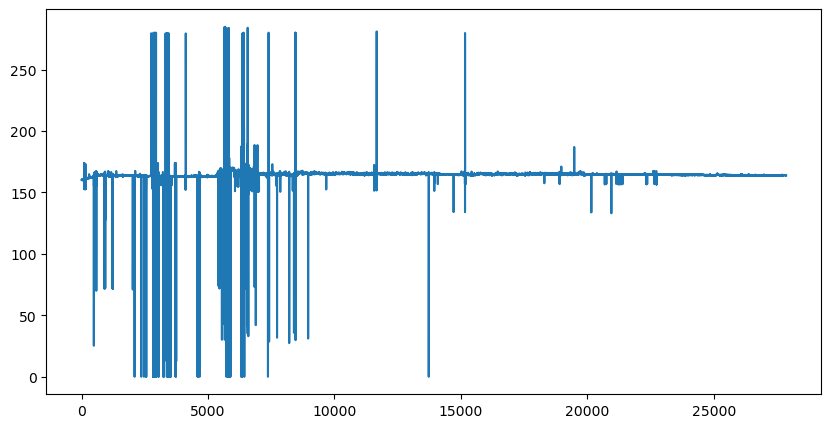

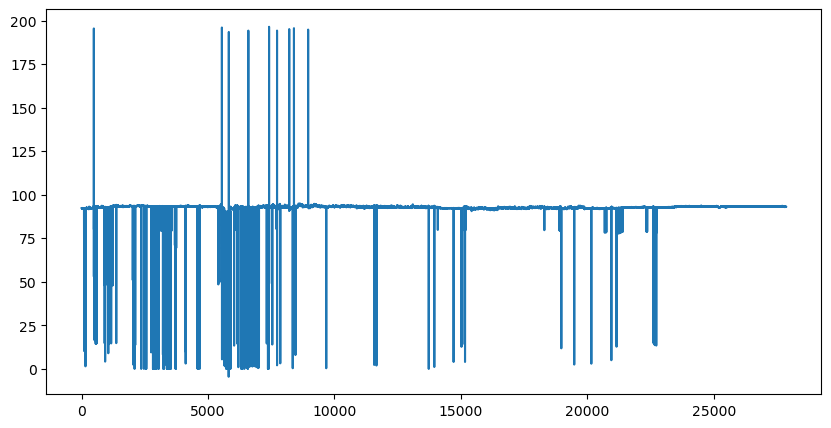

In [62]:
plt.figure(figsize=(10,5))
plt.plot(closest_ellipse_x_timeseries)
# plt.xlim([0,2000])
plt.show()
plt.figure(figsize=(10,5))
plt.plot(closest_ellipse_y_timeseries)
plt.show()